In [3]:
# Import required python libraries

%matplotlib inline

import pandas as pd
import numpy as np
import yfinance as yf
import math
import datetime as dt
import matplotlib.pyplot as plt
import mplfinance as mpf

print(yf.__version__)

0.2.58


In [4]:
# Use Yahoo Finance python package to obtain OHLCV data for desired system set

symbol = '^GSPC'
start = "2023-11-13"
end = dt.datetime.now().strftime('%Y-%m-%d') 
end = '2025-11-15'
ohlcv = yf.download(
    symbol, 
    start, 
    end,
    group_by="Ticker",  
    auto_adjust=True
)
ohlcv = ohlcv[symbol]
ohlcv

[*********************100%***********************]  1 of 1 completed


Price,Open,High,Low,Close,Volume
Date,,,,,
2023-11-13,4406.660156,4421.759766,4393.819824,4411.549805,3326240000
2023-11-14,4458.970215,4508.669922,4458.970215,4495.700195,4700350000
2023-11-15,4505.299805,4521.169922,4495.310059,4502.879883,4347170000
2023-11-16,4497.080078,4511.990234,4487.830078,4508.240234,3964520000
2023-11-17,4509.549805,4520.120117,4499.660156,4514.020020,3777240000
...,...,...,...,...,...
2025-11-10,6785.359863,6841.319824,6770.560059,6832.430176,5366050000
2025-11-11,6815.640137,6855.129883,6806.870117,6846.609863,4983490000
2025-11-12,6867.770020,6869.910156,6829.620117,6850.919922,5293610000


In [5]:
# three functions to implement concepts: 1) super_smoother 2) reversion_index and
# 3) plot_reversion_index to plot assocaited signals

def super_smoother(price: pd.Series, period: float) -> pd.Series:
    """
    Vectorized Ehlers SuperSmoother filter (© John F. Ehlers)
    
    Parameters
    ----------
    price : pd.Series
        Input price series (e.g., closing prices)
    period : float
        Smoothing period

    Returns
    -------
    pd.Series
        Smoothed price series
    """
    q = np.exp(-1.414 * np.pi / period)
    c1 = 2 * q * np.cos(np.radians(1.414 * 180 / period))
    c2 = q * q
    a0 = (1 - c1 + c2) / 2

    price_vals = price.to_numpy()
    out_values = np.zeros_like(price_vals)
    
    # Initialize first four values to the original price
    out_values[:4] = price_vals[:4]

    # Apply recursive filter from index 4 onward
    for i in range(4, len(price_vals)):
        out_values[i] = a0 * (price_vals[i] + price_vals[i-1]) + c1 * out_values[i-1] - c2 * out_values[i-2]

    return pd.Series(out_values, index=price.index)


def reversion_index(close: pd.Series, length: int = 20) -> pd.DataFrame:
    """
    Ehlers Reversion Index (© 2025 John F. Ehlers)
    Correct and fully vectorized Python version.
    """
    close = close.astype(float)
    
    # Delta: change from previous bar
    delta = close.diff().fillna(0)
    
    # Rolling sums of delta and absolute delta
    delta_sum = delta.rolling(window=length, min_periods=1).sum()
    abs_delta_sum = delta.abs().rolling(window=length, min_periods=1).sum()
    
    # Ratio: safely avoid division by zero
    ratio = delta_sum / abs_delta_sum.replace(0, np.nan)
    ratio = ratio.fillna(0)
    
    # Smooth and trigger lines
    smooth = super_smoother(ratio, period=8)
    trigger = super_smoother(ratio, period=4)
    
    return pd.DataFrame({
        'ReversionSmooth': smooth,
        'ReversionTrigger': trigger
    }, index=close.index)


def plot_reversion_index(df):
    
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 6), sharex=True, gridspec_kw={'height_ratios':[2,2]})
    
    # ----- Top: Price & SuperSmoother -----
    ax1.plot(df.index, df['Close'], label='Close', linewidth=1)
    ax1.plot(df.index, df['SuperSmoother'], label='SuperSmoother', linewidth=2, alpha=0.6, color='orange')
    
    # Shading for bullish/bearish signals
    ax1.fill_between(df.index, df['Close'].min(), df['Close'].max(), 
                     where=df['Signal'] == 1, color='green', alpha=0.1)
    ax1.fill_between(df.index, df['Close'].min(), df['Close'].max(), 
                     where=df['Signal'] == -1, color='red', alpha=0.1)
    
    ax1.set_title('Price & SuperSmoother with Signal')
    ax1.grid(True)
    ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    # ----- Bottom: ReversionSmooth & ReversionTrigger -----
    ax2.plot(df.index, df['ReversionSmooth'], label='ReversionSmooth', linewidth=1, color='red')
    ax2.plot(df.index, df['ReversionTrigger'], label='ReversionTrigger', linewidth=1, color='darkblue')
    ax2.axhline(0, color='gray', linestyle='--', linewidth=1)
    
    # Overlay Signal as step plot
    #ax2.step(df.index, df['Signal'], where='mid', label='Signal', color='purple', linewidth=1.5, alpha=0.5)
    
    ax2.set_title('Reversion Index with Signal')
    ax2.grid(True)
    ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    # ----- Improve date formatting on the bottom subplot -----
    ax2.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax2.xaxis.set_major_formatter(mdates.ConciseDateFormatter(mdates.AutoDateLocator()))
    plt.setp(ax2.get_xticklabels(), rotation=0, ha='center')  # horizontal, centered
    
    #plt.xlabel('Date')
    plt.tight_layout()
    plt.show()


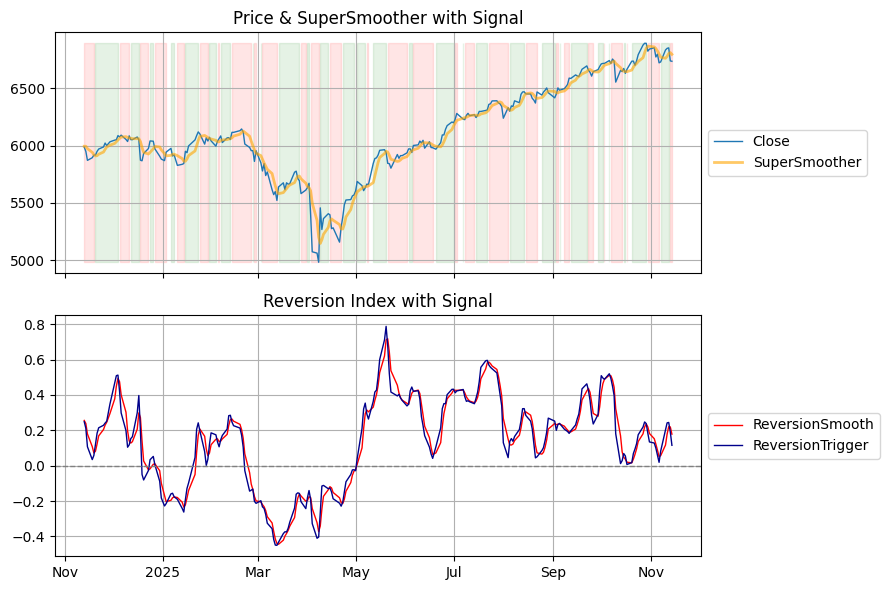

In [6]:
# Call functions to run required calculations. Set buy when ReversionTrigger swings above ReversionSmooth
# and sell for when ReversionTrigger swings below. Different period and lengths can be tested to determine
# optimum settings. Top plot close vs the SuperSmoother and red and white background shading to show highlight
# when buy and sell signals are active. Using slicing to plot last 1 year (aka 252 trading days).

df = ohlcv.copy()
df['SuperSmoother'] = super_smoother(df['Close'], period=10)
df = df.join(reversion_index(df['Close'], length=20))
df['Signal'] = np.where(df['ReversionTrigger'] > df['ReversionSmooth'], 1, -1)
plot_reversion_index(df[-252:])